In [1]:
import pandas as pd

In [3]:
def generate_features(df):
    """
    Generate features for a stock/index based on historical price and performance
    @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
    @return: dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new


In [4]:
data_raw = pd.read_csv('desktop/AAPL.csv', index_col='Date')
data = generate_features(data_raw)

start_train = '1988-01-04'
end_train = '2017-12-31'

start_test = '2018-01-01'
end_test = '2018-12-31'


In [5]:
data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values

print(X_train.shape)
print(y_train.shape)


(7307, 37)
(7307,)


In [6]:
data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)


In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

tf.random.set_seed(42)


model = Sequential([
    Dense(units=32, activation='relu'),
    Dense(units=1)
])


model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.1))

2023-08-06 20:28:33.897105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.fit(X_scaled_train, y_train, epochs=100, verbose=True)

predictions = model.predict(X_scaled_test)[:, 0]

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f'MSE: {mean_squared_error(y_test, predictions):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')

Epoch 1/100
229/229 [==============================] - 1s 522us/step - loss: 3.3252
Epoch 2/100
229/229 [==============================] - 0s 499us/step - loss: 0.2487
Epoch 3/100
229/229 [==============================] - 0s 506us/step - loss: 0.2790
Epoch 4/100
229/229 [==============================] - 0s 490us/step - loss: 0.2182
Epoch 5/100
229/229 [==============================] - 0s 487us/step - loss: 0.3220
Epoch 6/100
229/229 [==============================] - 0s 484us/step - loss: 0.4610
Epoch 7/100
229/229 [==============================] - 0s 487us/step - loss: 0.1666
Epoch 8/100
229/229 [==============================] - 0s 485us/step - loss: 0.3688
Epoch 9/100
229/229 [==============================] - 0s 501us/step - loss: 1.0608
Epoch 10/100
229/229 [==============================] - 0s 497us/step - loss: 0.1574
Epoch 11/100
229/229 [==============================] - 0s 486us/step - loss: 0.1692
Epoch 12/100
229/229 [==============================] - 0s 496us/step - lo

In [9]:

from tensorboard.plugins.hparams import api as hp
HP_HIDDEN = hp.HParam('hidden_size', hp.Discrete([64, 32, 16]))
HP_EPOCHS = hp.HParam('epochs', hp.Discrete([300, 1000]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.01, 0.4))



In [10]:
def train_test_model(hparams, logdir):
    model = Sequential([
        Dense(units=hparams[HP_HIDDEN], activation='relu'),
        Dense(units=1)
    ])
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(hparams[HP_LEARNING_RATE]),
                  metrics=['mean_squared_error'])
    model.fit(X_scaled_train, y_train, validation_data=(X_scaled_test, y_test), epochs=hparams[HP_EPOCHS], verbose=False,
              callbacks=[
                  tf.keras.callbacks.TensorBoard(logdir),  # log metrics
                  hp.KerasCallback(logdir, hparams),  # log hparams
                  tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss', min_delta=0, patience=200, verbose=0, mode='auto',
                  )
              ],
              )
    _, mse = model.evaluate(X_scaled_test, y_test)
    pred = model.predict(X_scaled_test)
    r2 = r2_score(y_test, pred)
    return mse, r2

In [11]:
def run(hparams, logdir):
    with tf.summary.create_file_writer(logdir).as_default():
        hp.hparams_config(
            hparams=[HP_HIDDEN, HP_EPOCHS, HP_LEARNING_RATE],
            metrics=[hp.Metric('mean_squared_error', display_name='mse'),
                     hp.Metric('r2', display_name='r2')],
        )
        mse, r2 = train_test_model(hparams, logdir)
        tf.summary.scalar('mean_squared_error', mse, step=1)
        tf.summary.scalar('r2', r2, step=1)



In [12]:
session_num = 0

for hidden in HP_HIDDEN.domain.values:
    for epochs in HP_EPOCHS.domain.values:
        for learning_rate in tf.linspace(HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value, 5):
            hparams = {
                HP_HIDDEN: hidden,
                HP_EPOCHS: epochs,
                HP_LEARNING_RATE: float("%.2f"%float(learning_rate)),
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run(hparams, 'logs/hparam_tuning/' + run_name)
            session_num += 1


--- Starting trial: run-0
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.01}
8/8 [==============================] - 0s 546us/step
--- Starting trial: run-1
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.11}
8/8 [==============================] - 0s 576us/step
--- Starting trial: run-2
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.21}
8/8 [==============================] - 0s 525us/step
--- Starting trial: run-3
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.3}
8/8 [==============================] - 0s 545us/step
--- Starting trial: run-4
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.4}
8/8 [==============================] - 0s 555us/step
--- Starting trial: run-5
{'hidden_size': 16, 'epochs': 1000, 'learning_rate': 0.01}
8/8 [==============================] - 0s 543us/step
--- Starting trial: run-6
{'hidden_size': 16, 'epochs': 1000, 'learning_rate': 0.11}
8/8 [==============================] - 0s 551us/step
--- Starting trial: run-7
{'hidden_size':

In [13]:
model = Sequential([
    Dense(units=16, activation='relu'),
    Dense(units=1)
])

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.21))

model.fit(X_scaled_train, y_train, epochs=1000, verbose=False)

predictions = model.predict(X_scaled_test)[:, 0]

8/8 [==============================] - 0s 1ms/step


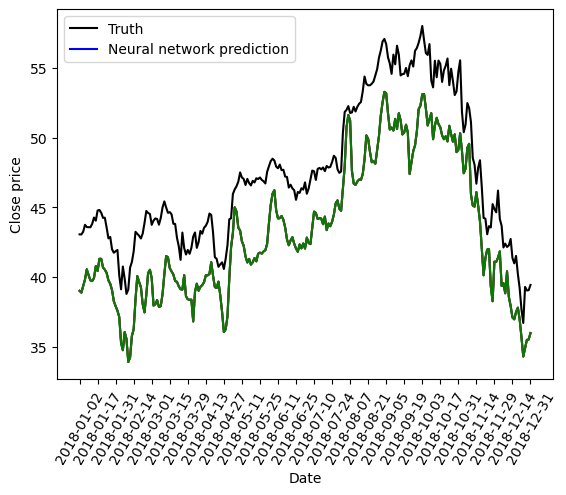

In [14]:

import matplotlib.pyplot as plt
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.plot(data_test.index, predictions, c='r')
plt.plot(data_test.index, predictions, c='g')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Neural network prediction'])
plt.show()